In [1]:
# importing modules and libraries

import matplotlib.pyplot as plt
import numpy as np
import keras
from keras.layers import Input, Input, Conv2D, MaxPooling2D, Flatten, ELU, Dense, BatchNormalization, Activation
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential
from keras.optimizers import Nadam

train = keras.utils.image_dataset_from_directory(
    "/kaggle/input/snake-dataset-india/Snake Images/train",
    image_size=(224, 224),
    batch_size=20
)

normalization_layer = keras.layers.Rescaling(1./255) # normalizing images from 0 to 255 to 0 to 1
normalized_dataset = train.map(lambda x, y: (normalization_layer(x), y)) # normalized images

images_list = [] # image container
labels_list = [] # label container

for images, labels in normalized_dataset: # taking out labels from folder name
    for image, label in zip(images, labels):
        image_array = image.numpy()
        images_list.append(image_array)
        labels_list.append(label.numpy())

image = np.asarray(images_list) # turning images to array

label = np.asarray(labels_list) # labels as arrays

2024-06-01 03:48:27.593257: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-01 03:48:27.593375: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-01 03:48:27.846297: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Found 1775 files belonging to 2 classes.


(-0.5, 223.5, 223.5, -0.5)

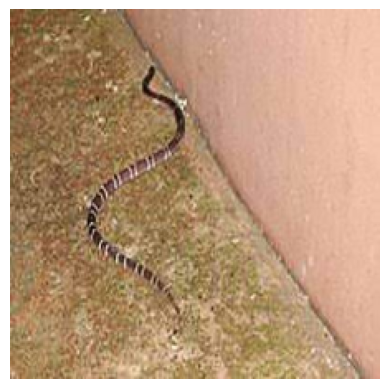

In [2]:
plt.imshow(image[150])
plt.axis('off')

(-0.5, 223.5, 223.5, -0.5)

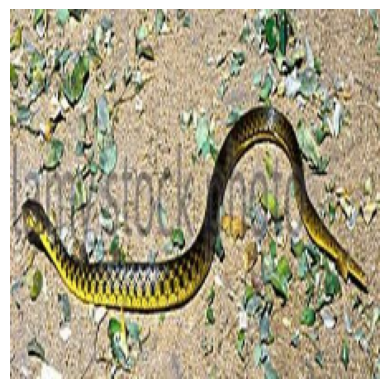

In [3]:
plt.imshow(image[250])
plt.axis('off')

In [4]:
from sklearn.model_selection import train_test_split

# Split the data
x_train, x_temp, y_train, y_temp = train_test_split(image, label, test_size=0.3, random_state=42)
x_test, x_val, y_test, y_val = train_test_split(x_temp, y_temp, test_size=0.5, random_state=42)

# Print shapes
print("x_train:", x_train.shape)
print("y_train:", y_train.shape)
print("x_test:", x_test.shape)
print("y_test:", y_test.shape)
print("x_val:", x_val.shape)
print("y_val:", y_val.shape)

x_train: (1242, 224, 224, 3)
y_train: (1242,)
x_test: (266, 224, 224, 3)
y_test: (266,)
x_val: (267, 224, 224, 3)
y_val: (267,)


### VGG16

In [5]:
from keras.applications import VGG16
from keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D
from keras.models import Model
from keras.callbacks import ReduceLROnPlateau

# Load the VGG16 model and create the feature extractor
vgg16_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
feature_extractor = Model(inputs=vgg16_model.input, outputs=vgg16_model.get_layer('block5_pool').output)

# Freeze the convolutional base layers
for layer in feature_extractor.layers:
    layer.trainable = False

# Add custom dense layers on top
x = feature_extractor.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
output = Dense(1, activation='sigmoid')(x)

# Create the final model
model = Model(inputs=feature_extractor.input, outputs=output)

model_checkpoint = ModelCheckpoint('model.keras', monitor='val_accuracy', save_best_only=True, verbose=1, mode='max')
reduce_lr = ReduceLROnPlateau(mode='min', monitor='val_loss', factor=0.1, patience=5, min_lr=0.00000001, verbose=1)

model.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │         1,025 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,241,025 (58.14 MB)

 Trainable params: 526,337 (2.01 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [6]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=20, batch_size=32,callbacks=[reduce_lr,model_checkpoint])

Epoch 1/20
 1/39 ━━━━━━━━━━━━━━━━━━━━ 20:02 32s/step - accuracy: 0.5625 - loss: 0.7029

I0000 00:00:1717167628.260585     116 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1717167628.281086     116 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 821ms/step - accuracy: 0.6369 - loss: 0.6573

W0000 00:00:1717167660.776432     113 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update



Epoch 1: val_accuracy improved from -inf to 0.68165, saving model to model.keras
39/39 ━━━━━━━━━━━━━━━━━━━━ 79s 1s/step - accuracy: 0.6374 - loss: 0.6566 - val_accuracy: 0.6816 - val_loss: 0.5876 - learning_rate: 0.0010
Epoch 2/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - accuracy: 0.7018 - loss: 0.5608
Epoch 2: val_accuracy improved from 0.68165 to 0.70787, saving model to model.keras
39/39 ━━━━━━━━━━━━━━━━━━━━ 7s 172ms/step - accuracy: 0.7021 - loss: 0.5607 - val_accuracy: 0.7079 - val_loss: 0.5623 - learning_rate: 0.0010
Epoch 3/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - accuracy: 0.7475 - loss: 0.5189
Epoch 3: val_accuracy did not improve from 0.70787
39/39 ━━━━━━━━━━━━━━━━━━━━ 6s 162ms/step - accuracy: 0.7473 - loss: 0.5190 - val_accuracy: 0.6929 - val_loss: 0.5601 - learning_rate: 0.0010
Epoch 4/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.7149 - loss: 0.5077
Epoch 4: val_accuracy did not improve from 0.70787
39/39 ━━━━━━━━━━━━━━━━━━━━ 6s 160ms/step - accuracy: 

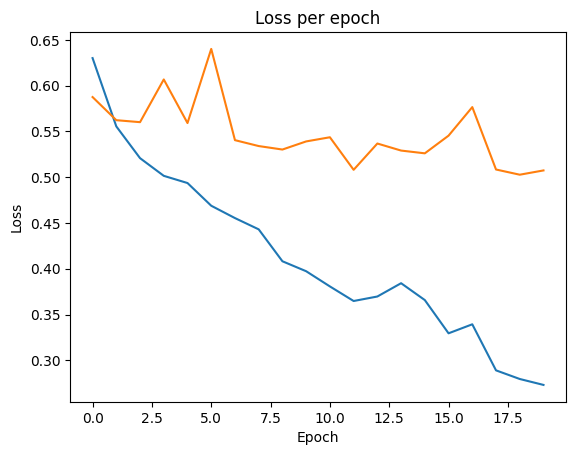

In [7]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss per epoch")
plt.show()

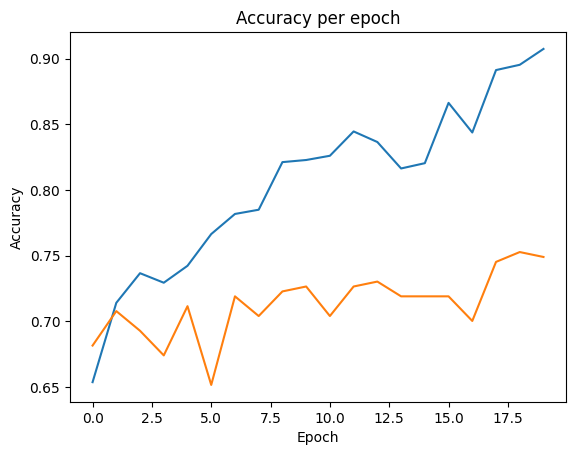

In [8]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy per epoch")
plt.show()

### ResNet50

In [9]:
from tensorflow.keras.applications import ResNet50

# Load the ResNet50 model and create the feature extractor
resnet50_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
feature_extractor = Model(inputs=resnet50_model.input, outputs=resnet50_model.get_layer('conv5_block3_out').output)

# Freeze the convolutional base layers
for layer in feature_extractor.layers:
    layer.trainable = False

# Add custom dense layers on top
x = feature_extractor.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)

output = Dense(1, activation='sigmoid')(x)

# Create the final model
model = Model(inputs=feature_extractor.input, outputs=output)

model_checkpoint = ModelCheckpoint('att_model.keras', monitor='val_accuracy', save_best_only=True, verbose=1, mode='max')
reduce_lr = ReduceLROnPlateau(mode='min', monitor='val_loss', factor=0.1, patience=5, min_lr=0.00000001, verbose=1)

# Print the model summary
model.summary()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_1[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 25,686,913 (97.99 MB)

 Trainable params: 2,099,201 (8.01 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [10]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=20, batch_size=32,callbacks=[reduce_lr,model_checkpoint])

Epoch 1/20
 2/39 ━━━━━━━━━━━━━━━━━━━━ 3s 84ms/step - accuracy: 0.2969 - loss: 1.3385 

W0000 00:00:1717167822.287872     114 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step - accuracy: 0.4984 - loss: 0.9968

W0000 00:00:1717167833.141442     114 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1717167837.516748     114 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update



Epoch 1: val_accuracy improved from -inf to 0.55431, saving model to att_model.keras


W0000 00:00:1717167843.300021     114 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


39/39 ━━━━━━━━━━━━━━━━━━━━ 37s 570ms/step - accuracy: 0.4989 - loss: 0.9928 - val_accuracy: 0.5543 - val_loss: 0.6827 - learning_rate: 0.0010
Epoch 2/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.5674 - loss: 0.7116
Epoch 2: val_accuracy improved from 0.55431 to 0.60674, saving model to att_model.keras
39/39 ━━━━━━━━━━━━━━━━━━━━ 5s 122ms/step - accuracy: 0.5676 - loss: 0.7112 - val_accuracy: 0.6067 - val_loss: 0.6756 - learning_rate: 0.0010
Epoch 3/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.6332 - loss: 0.6500
Epoch 3: val_accuracy did not improve from 0.60674
39/39 ━━━━━━━━━━━━━━━━━━━━ 4s 102ms/step - accuracy: 0.6326 - loss: 0.6503 - val_accuracy: 0.6067 - val_loss: 0.6660 - learning_rate: 0.0010
Epoch 4/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.6249 - loss: 0.6468
Epoch 4: val_accuracy improved from 0.60674 to 0.61423, saving model to att_model.keras
39/39 ━━━━━━━━━━━━━━━━━━━━ 5s 122ms/step - accuracy: 0.6244 - loss: 0.6471 - val_accuracy: 0.6

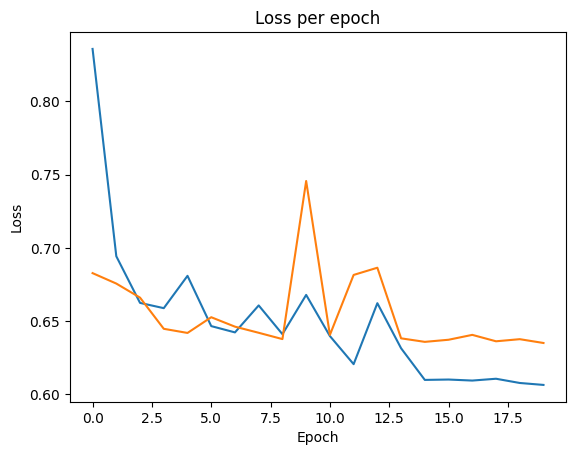

In [11]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss per epoch")
plt.show()

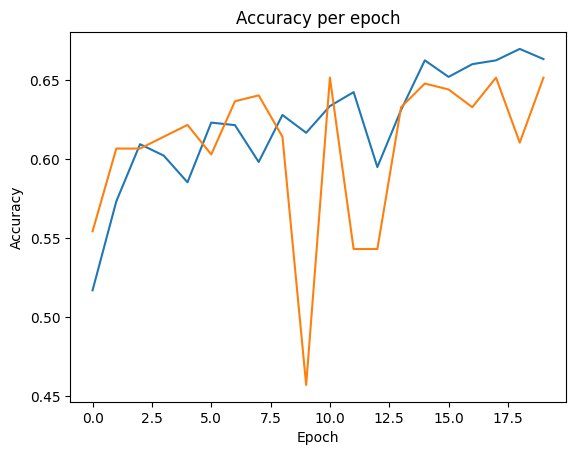

In [12]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy per epoch")
plt.show()

### InceptionV3

In [13]:
from tensorflow.keras.applications import InceptionV3

# Load the InceptionV3 model and create the feature extractor
inception_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
feature_extractor = Model(inputs=inception_model.input, outputs=inception_model.get_layer('mixed10').output)

# Freeze the convolutional base layers
for layer in feature_extractor.layers:
    layer.trainable = False

# Add custom dense layers on top
x = feature_extractor.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)

output = Dense(1, activation='sigmoid')(x)

# Create the final model
model = Model(inputs=feature_extractor.input, outputs=output)

model_checkpoint = ModelCheckpoint('att_model.keras', monitor='val_accuracy', save_best_only=True, verbose=1, mode='max')
reduce_lr = ReduceLROnPlateau(mode='min', monitor='val_loss', factor=0.1, patience=5, min_lr=0.00000001, verbose=1)

# Print the model summary
model.summary()

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 111, 111,  │        864 │ input_layer_2[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 111, 111,  │         96 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 111, 111,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 109, 109,  │      9,216 │ activation[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 109, 109,  │         96 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 109, 109,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 109, 109,  │     18,432 │ activation_1[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 109, 109,  │        192 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 109, 109,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 54, 54,    │          0 │ activation_2[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 54, 54,    │      5,120 │ max_pooling2d[0]… │
│                     │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 54, 54,    │        240 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 54, 54,    │          0 │ batch_normalizat… │
│ (Activation)        │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 52, 52,    │    138,240 │ activation_3[0][… │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 52, 52,    │        576 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 52, 52,    │          0 │ batch_normalizat

 Total params: 23,901,985 (91.18 MB)

 Trainable params: 2,099,201 (8.01 MB)

 Non-trainable params: 21,802,784 (83.17 MB)

In [14]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=20, batch_size=32,callbacks=[reduce_lr,model_checkpoint])

Epoch 1/20
 2/39 ━━━━━━━━━━━━━━━━━━━━ 3s 99ms/step - accuracy: 0.5625 - loss: 1.3575  

W0000 00:00:1717167950.564707     116 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 436ms/step - accuracy: 0.6269 - loss: 1.2354

W0000 00:00:1717167967.134152     114 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1717167973.737185     116 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update



Epoch 1: val_accuracy improved from -inf to 0.79775, saving model to att_model.keras


W0000 00:00:1717167984.504000     114 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


39/39 ━━━━━━━━━━━━━━━━━━━━ 57s 918ms/step - accuracy: 0.6283 - loss: 1.2262 - val_accuracy: 0.7978 - val_loss: 0.4201 - learning_rate: 0.0010
Epoch 2/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.8420 - loss: 0.3539
Epoch 2: val_accuracy improved from 0.79775 to 0.83521, saving model to att_model.keras
39/39 ━━━━━━━━━━━━━━━━━━━━ 4s 108ms/step - accuracy: 0.8420 - loss: 0.3540 - val_accuracy: 0.8352 - val_loss: 0.3754 - learning_rate: 0.0010
Epoch 3/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.8703 - loss: 0.2996
Epoch 3: val_accuracy did not improve from 0.83521
39/39 ━━━━━━━━━━━━━━━━━━━━ 3s 79ms/step - accuracy: 0.8702 - loss: 0.2999 - val_accuracy: 0.7678 - val_loss: 0.4558 - learning_rate: 0.0010
Epoch 4/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.8936 - loss: 0.2608
Epoch 4: val_accuracy did not improve from 0.83521
39/39 ━━━━━━━━━━━━━━━━━━━━ 3s 78ms/step - accuracy: 0.8935 - loss: 0.2612 - val_accuracy: 0.8315 - val_loss: 0.3650 - learning_rate:

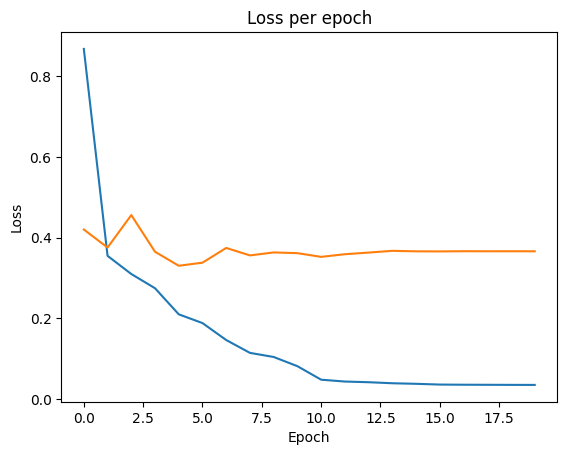

In [15]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss per epoch")
plt.show()

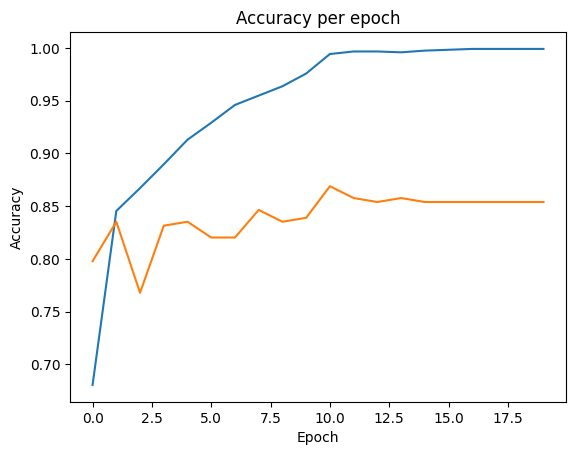

In [16]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy per epoch")
plt.show()

### EfficientNetB7

In [17]:
from tensorflow.keras.applications import EfficientNetB7

# Load the EfficientNetB7 model and create the feature extractor
efficientnet_model = EfficientNetB7(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
feature_extractor = Model(inputs=efficientnet_model.input, outputs=efficientnet_model.get_layer('top_activation').output)

# Freeze the convolutional base layers
for layer in feature_extractor.layers:
    layer.trainable = False

# Add custom layers on top
x = feature_extractor.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)

output = Dense(1, activation='sigmoid')(x)

# Create the final model
model = Model(inputs=feature_extractor.input, outputs=output)

model_checkpoint = ModelCheckpoint('att_model.keras', monitor='val_accuracy', save_best_only=True, verbose=1, mode='max')
reduce_lr = ReduceLROnPlateau(mode='min', monitor='val_loss', factor=0.1, patience=5, min_lr=0.00000001, verbose=1)

# Print the model summary
model.summary()

258076736/258076736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "functional_15"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 224, 224,  │          0 │ input_layer_3[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 224, 224,  │          7 │ rescaling_1[0][0] │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_2         │ (None, 224, 224,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 225, 225,  │          0 │ rescaling_2[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │      1,728 │ stem_conv_pad[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        256 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 112, 112,  │        576 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 112, 112,  │        256 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 112, 112,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 64)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 64)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 16)  │      1,040 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 64)  │      1,088 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 112, 112,  │          0 │ block1a_activati… │
│ (Multiply)          │ 64)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │      2,048 │ block1a_se_excit

 Total params: 66,721,176 (254.52 MB)

 Trainable params: 2,623,489 (10.01 MB)

 Non-trainable params: 64,097,687 (244.51 MB)

In [18]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=20, batch_size=32,callbacks=[reduce_lr,model_checkpoint])

Epoch 1/20


W0000 00:00:1717168190.932245     116 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.5471 - loss: 0.9047   

W0000 00:00:1717168296.043126     115 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1717168312.304892     113 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update



Epoch 1: val_accuracy improved from -inf to 0.60674, saving model to att_model.keras


W0000 00:00:1717168328.356782     113 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


39/39 ━━━━━━━━━━━━━━━━━━━━ 274s 4s/step - accuracy: 0.5472 - loss: 0.9016 - val_accuracy: 0.6067 - val_loss: 0.6833 - learning_rate: 0.0010
Epoch 2/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step - accuracy: 0.5767 - loss: 0.6893
Epoch 2: val_accuracy did not improve from 0.60674
39/39 ━━━━━━━━━━━━━━━━━━━━ 12s 310ms/step - accuracy: 0.5767 - loss: 0.6892 - val_accuracy: 0.6067 - val_loss: 0.6723 - learning_rate: 0.0010
Epoch 3/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step - accuracy: 0.5779 - loss: 0.6938
Epoch 3: val_accuracy did not improve from 0.60674
39/39 ━━━━━━━━━━━━━━━━━━━━ 12s 307ms/step - accuracy: 0.5777 - loss: 0.6938 - val_accuracy: 0.6067 - val_loss: 0.6704 - learning_rate: 0.0010
Epoch 4/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step - accuracy: 0.6005 - loss: 0.6769
Epoch 4: val_accuracy did not improve from 0.60674
39/39 ━━━━━━━━━━━━━━━━━━━━ 12s 301ms/step - accuracy: 0.6005 - loss: 0.6770 - val_accuracy: 0.6067 - val_loss: 0.6739 - learning_rate: 0.0010
Epoch 5/20
39/39 ━━━━━━

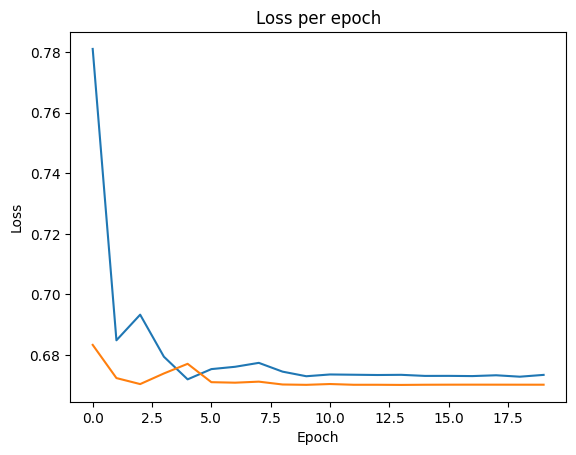

In [19]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss per epoch")
plt.show()

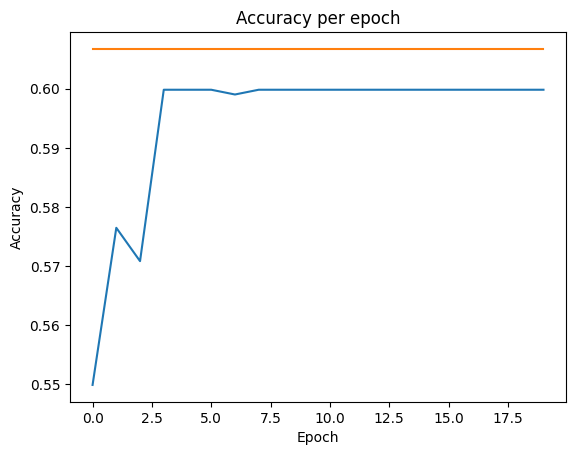

In [20]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy per epoch")
plt.show()

### CNN

In [110]:
from keras.models import Sequential
from keras.layers import GlobalAveragePooling2D, InputLayer
from keras.callbacks import ReduceLROnPlateau
from keras.regularizers import l1_l2

model = Sequential()

model.add(InputLayer(shape=(224, 224, 3)))

model.add(Conv2D(64, 3, activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=2))

model.add(Conv2D(64, 3, activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=2))

model.add(Conv2D(64, 3, activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=2))

model.add(Conv2D(64, 3, activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=2))

model.add(GlobalAveragePooling2D())

model.add(Dense(1024, activation='relu'))

model.add(Dense(1, activation='sigmoid'))

model.summary()

model_checkpoint = ModelCheckpoint('model.keras', monitor='val_accuracy', save_best_only=True, verbose=1, mode='max')

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_125 (Conv2D)             │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_113         │ (None, 224, 224, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_113               │ (None, 112, 112, 64)   │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_126 (Conv2D)             │ (None, 112, 112, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_114         │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_114               │ (None, 56, 56, 64)     │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_127 (Conv2D)             │ (None, 56, 56, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_115         │ (None, 56, 56, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_115               │ (None, 28, 28, 64)     │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_128 (Conv2D)             │ (None, 28, 28, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_116         │ (None, 28, 28, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_116               │ (None, 14, 14, 64)     │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_19     │ (None, 64)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_56 (Dense)                │ (None, 1024)           │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_57 (Dense)                │ (None, 1)              │         1,025 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 181,185 (707.75 KB)

 Trainable params: 180,673 (705.75 KB)

 Non-trainable params: 512 (2.00 KB)

In [111]:
model.compile(optimizer=Nadam(learning_rate=0.00005), loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=50, batch_size=32,callbacks=[model_checkpoint])

Epoch 1/50
 2/39 ━━━━━━━━━━━━━━━━━━━━ 3s 98ms/step - accuracy: 0.5469 - loss: 0.6898

W0000 00:00:1717187096.253107     112 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - accuracy: 0.6032 - loss: 0.6745

W0000 00:00:1717187102.395177     110 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update



Epoch 1: val_accuracy improved from -inf to 0.40075, saving model to model.keras
39/39 ━━━━━━━━━━━━━━━━━━━━ 16s 213ms/step - accuracy: 0.6033 - loss: 0.6743 - val_accuracy: 0.4007 - val_loss: 0.6970
Epoch 2/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.6250 - loss: 0.6540
Epoch 2: val_accuracy did not improve from 0.40075
39/39 ━━━━━━━━━━━━━━━━━━━━ 3s 78ms/step - accuracy: 0.6248 - loss: 0.6541 - val_accuracy: 0.4007 - val_loss: 0.7040
Epoch 3/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.6137 - loss: 0.6569
Epoch 3: val_accuracy did not improve from 0.40075
39/39 ━━━━━━━━━━━━━━━━━━━━ 3s 78ms/step - accuracy: 0.6140 - loss: 0.6567 - val_accuracy: 0.4007 - val_loss: 0.7127
Epoch 4/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.6730 - loss: 0.6162
Epoch 4: val_accuracy did not improve from 0.40075
39/39 ━━━━━━━━━━━━━━━━━━━━ 3s 78ms/step - accuracy: 0.6720 - loss: 0.6167 - val_accuracy: 0.4007 - val_loss: 0.7261
Epoch 5/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 73m

In [112]:
# loading best model and testing

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

model1 = keras.models.load_model('model.keras', custom_objects={"ELU": keras.layers.ELU,"PReLU": keras.layers.PReLU}) # loading saved model

y_pred = model1.predict(x_test) # predicting

y_pred = y_pred = (y_pred > 0.5).astype(int)

# Accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Precision
precision = precision_score(y_test, y_pred)
print("Precision:", precision)

# Recall
recall = recall_score(y_test, y_pred)
print("Recall:", recall)

# F1 Score
f1 = f1_score(y_test, y_pred)
print("F1 Score:", f1)

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step
Accuracy: 0.7443609022556391
Precision: 0.75
Recall: 0.8108108108108109
F1 Score: 0.7792207792207791
Confusion Matrix:
[[ 78  40]
 [ 28 120]]


In [113]:
model1.evaluate(x_test,y_test)

9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 83ms/step - accuracy: 0.7319 - loss: 0.6041


[0.576769232749939, 0.7443609237670898]

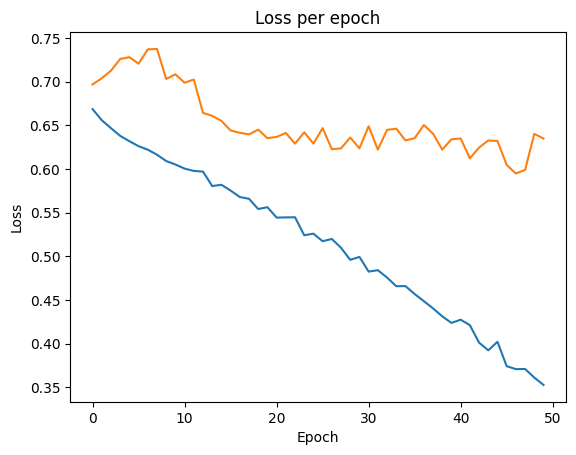

In [114]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss per epoch")
plt.show()

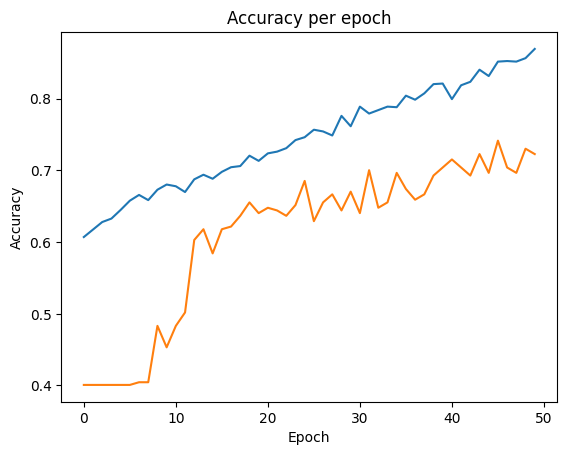

In [115]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy per epoch")
plt.show()